# Evaluación de modelos

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

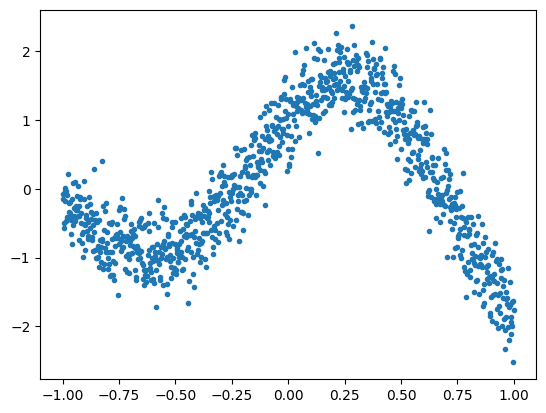

In [ ]:
X = np.linspace(-1, 1, 1000)
ruido = np.random.normal(0, 0.333, 1000)
y = np.sin(4*X) + np.cos(3*X) + ruido
plt.plot(X,y, '.');

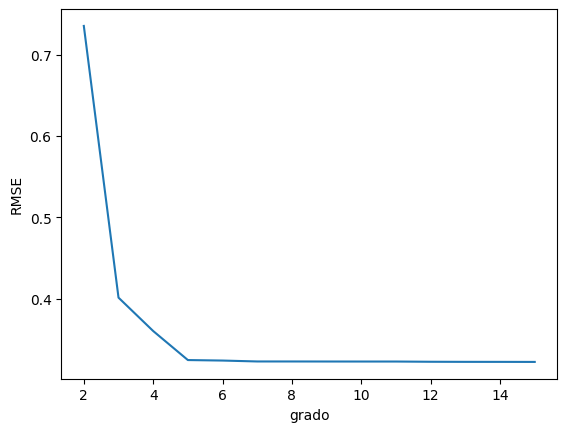

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures

X = X.reshape(-1,1)
pipe = Pipeline([('poly', PolynomialFeatures()), ('model', LinearRegression(fit_intercept=True))])
degrees = range(2,16)
scores_rmse = []
for degree in degrees:
  pipe.set_params(poly__degree = degree).fit(X, y)
  scores_rmse.append(root_mean_squared_error(y, pipe.predict(X)))

fig = plt.figure()
plt.plot(degrees, scores_rmse, '-')
plt.xlabel('grado')
plt.ylabel('RMSE');

# Errores de entrenamiento y prueba, sub-ajuste y sobre-ajuste

Parece que evidentemente el modelo mejora a medida que lo hacemos más complejo generando características de grados más elevados.

¿Dado lo anterior, podemos decir los modelos más complejos predicen mejor? Eso solo podemos saberlo con **datos diferentes** a los usados para entrenar el modelo.

En este caso vamos a generar un nuevo conjunto de datos con características estadísticas similares al del conjunto de datos que usamos para entrenar el modelo.

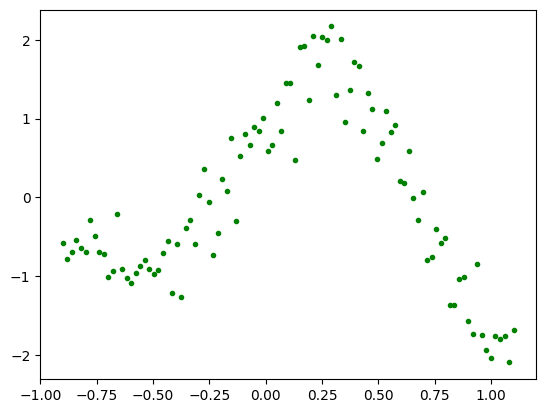

In [ ]:
X_test = np.linspace(-0.9, 1.1, 100)
ruido = np.random.normal(0, 0.333, 100)
y_test = np.sin(4*X_test) + np.cos(3*X_test) + ruido
plt.plot(X_test, y_test, '.g');

Text(0, 0.5, 'RMSE')

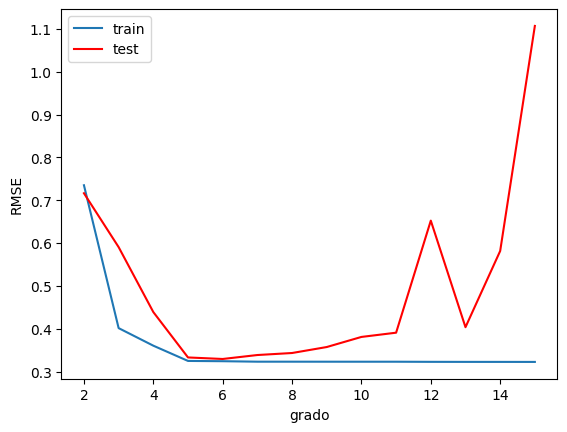

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('poly', PolynomialFeatures()), ('model', LinearRegression(fit_intercept=True))])
degrees = range(2,16)
scores_train = []
scores_test = []
for degree in degrees:
  pipe.set_params(poly__degree = degree).fit(X, y)
  scores_train.append(root_mean_squared_error(y, pipe.predict(X)))
  scores_test.append(root_mean_squared_error(y_test, pipe.predict(X_test.reshape(-1,1))))
plt.plot(degrees, scores_train, '-', label='train')
plt.plot(degrees, scores_test, '-r', label='test')
plt.legend()
plt.xlabel('grado')
plt.ylabel('RMSE')

Se observa que a medida que aumenta la complejidad del modelo (en este caso a través del grado de la función polinómica cuyos coeficientes se quieren ajustar), el error del conjunto de datos de entrenamiento tiende a reducirse, pero en el caso del error con datos nuevos (que suelen llamarse conjunto de datos de **prueba**), el error se comporta distinto: disminuye hasta cierto grado de complejidad y después vuelve a aumentar.

Teniendo en cuenta lo anterior, se dice que sí aún no hemos llegado al **error de prueba** mìnimo que se puede obtener con ese modelo en particular, el modelo está **sub-ajustado**, y sí ya pasamos el mínimo y seguimos aumentando la complejidad del modelo lo estamos **sobre-ajustando**.

# Partición de los datos en conjuntos de entrenamiento y prueba

No siempre es posible tener un conjunto de datos nuevos, así que el conjunto de datos de prueba se suele extraer del conjunto de datos con que se cuenta. De esta manera, quedaremos con 2 conjuntos de datos, uno de entrenamiento y otro de prueba.

La partición de los datos debería hacerse de manera aleatoria, excepto con los datos de tiempo. El método train_test_split permite hacer esta partición fácilmente.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, train_size=0.8)
print(f'Tamaño del conjunto de entrenamiento es: {X_train.shape}')
print(f'Tamaño del conjunto de prueba es: {X_test.shape}')

Tamaño del conjunto de entrenamiento es: (800, 1)
Tamaño del conjunto de prueba es: (200, 1)


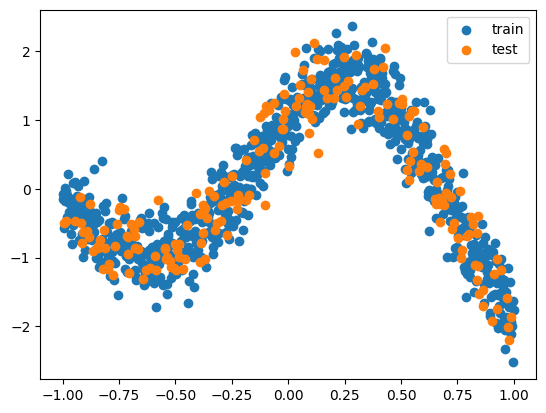

In [ ]:
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()

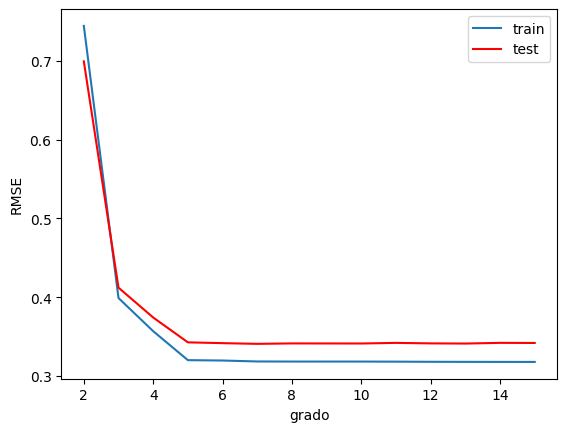

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('poly', PolynomialFeatures()), ('model', LinearRegression(fit_intercept=True))])
degrees = range(2,16)
scores_train = []
scores_test = []
for degree in degrees:
  pipe.set_params(poly__degree = degree).fit(X_train, y_train)
  scores_train.append(root_mean_squared_error(y_train, pipe.predict(X_train)))
  scores_test.append(root_mean_squared_error(y_test, pipe.predict(X_test.reshape(-1,1))))
plt.plot(degrees, scores_train, '-', label='train')
plt.plot(degrees, scores_test, '-r', label='test')
plt.legend()
plt.xlabel('grado')
plt.ylabel('RMSE');

¿Con esto quedamos tranquilos? En realidad no.

Para saber si nuestro modelo predice bien deberíamos **ajustarlo** con muchos conjuntos de entrenamiento y **evaluarlo** con muchos conjuntos de prueba. El promedio de los errores obtenidos en los conjuntos de prueba sería lo más cercano a un **error de generalización**.

Una forma de hacerlo es usando **validación cruzada**. En Scikit Learn el método cross_val_score me permite usar esta técnica de remuestreo.

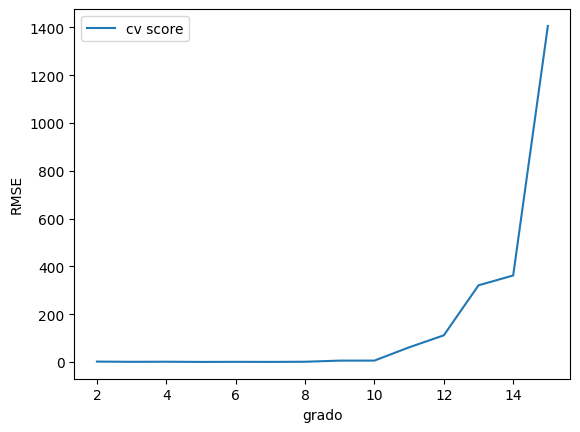

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
pipe = Pipeline([('poly', PolynomialFeatures()), ('model', LinearRegression(fit_intercept=True))])
degrees = range(2,16)
mean_scores_cv = []
for degree in degrees:
  score = cross_val_score(estimator = pipe.set_params(poly__degree = degree), X=X , y=y, cv=5, scoring='neg_root_mean_squared_error')
  mean_scores_cv.append(-score.mean())
plt.plot(degrees, mean_scores_cv, '-', label='cv score')
plt.legend()
plt.xlabel('grado')
plt.ylabel('RMSE');

Observamos que con grados grandes, mayores a 10, el RMSE del modelo se dispara. Vamos a hacer zoom en los modelos de grados más bajos.

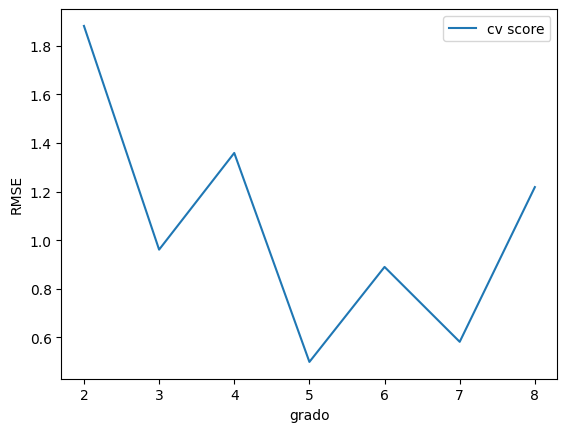

In [ ]:
plt.plot(degrees[:7], mean_scores_cv[:7], '-', label='cv score')
plt.legend()
plt.xlabel('grado')
plt.ylabel('RMSE');

In [ ]:
scores = pd.DataFrame(data = [degrees, mean_scores_cv], index=['grado', 'RMSE']).T
scores.set_index('grado', inplace=True)
scores

,RMSE
grado,
2.0,1.880632
3.0,0.961129
4.0,1.358529
5.0,0.499616
6.0,0.890086
7.0,0.582261
8.0,1.218209
9.0,5.944992
10.0,6.020599


In [ ]:
print(f'Best RMSE is {np.min(mean_scores_cv):.3f}, with degree {degrees[np.argmin(mean_scores_cv)]}.')

Best RMSE is 0.500, with degree 5.


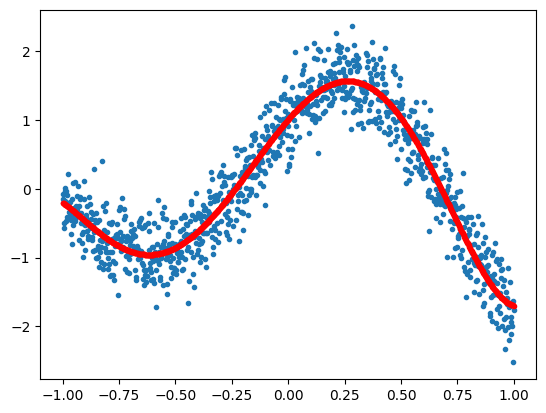

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=degrees[np.argmin(mean_scores_cv)], include_bias=True)
X_p = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_p, y)
plt.plot(X,y, '.')
plt.plot(X, model.predict(X_p), 'r.');

Los coeficientes del modelo serían:

In [ ]:
coeficientes = pd.DataFrame(data=[poly.get_feature_names_out(), model.coef_], index=['grado', 'coeficientes']).T
coeficientes.set_index('grado', inplace=True)
coeficientes

,coeficientes
grado,
1,0.0
x0,3.77368
x0^2,-4.268183
x0^3,-8.5834
x0^4,2.311055
x0^5,4.061633


In [ ]:
model.intercept_

1.0074436532723647

# Ejercicio

Descargar el dataset 'auto-mpg.data-original', disponible en https://archive.ics.uci.edu/dataset/9/auto+mpg.

Prepare los datos.


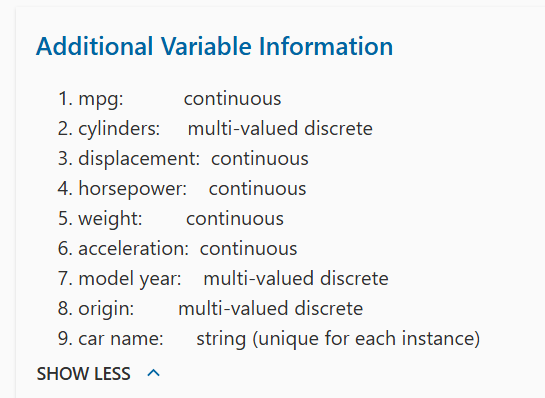

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error, median_absolute_error

In [3]:
data = "/auto-mpg.data-original_"
columnas=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
df = pd.read_csv(data, sep='\s+', names=columnas)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     406 non-null    float64
 2   displacement  406 non-null    float64
 3   horsepower    400 non-null    float64
 4   weight        406 non-null    float64
 5   acceleration  406 non-null    float64
 6   model_year    406 non-null    float64
 7   origin        406 non-null    float64
 8   car_name      406 non-null    object 
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


In [4]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    float64
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    float64
 7   origin        392 non-null    float64
 8   car_name      392 non-null    object 
dtypes: float64(8), object(1)
memory usage: 30.6+ KB


Haga un modelo de regresión lineal polinómica que prediga la variable 'mpg' usando como variable predictora 'displacement'. Para esto haga una partición de los datos en subconjuntos de entrenamiento y prueba en una proporciòn 70/30, usando random_state=1.

Reporte el grado del polinomio óptimo, el RMSE de entrenamiento y el de prueba con el grado óptimo, el intercepto y las pendientes del modelo.

In [32]:
X = df[['displacement']]
y = df['mpg']

#entrenamiento 70 y prueba 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f'Tamaño del conjunto de entrenamiento es: {X_train.shape}')
print(f'Tamaño del conjunto de prueba es: {X_test.shape}')

Tamaño del conjunto de entrenamiento es: (274, 1)
Tamaño del conjunto de prueba es: (118, 1)


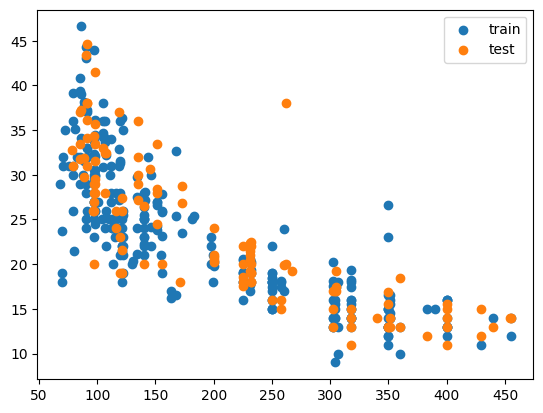

In [33]:
plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.legend()

In [35]:
polinomio = PolynomialFeatures(degree=3)
X_train_poly = polinomio.fit_transform(X_train)
X_test_poly = polinomio.transform(X_test)

In [36]:
#entrenamiento
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [37]:
#predicciones
y_pred = model.predict(X_test_poly)

In [38]:
error_cuadratico = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"error cuadratico medio: {error_cuadratico:.2f}")
print(f"coeficiente: {r2:.2f}")

error cuadratico medio: 20.26
coeficiente: 0.70


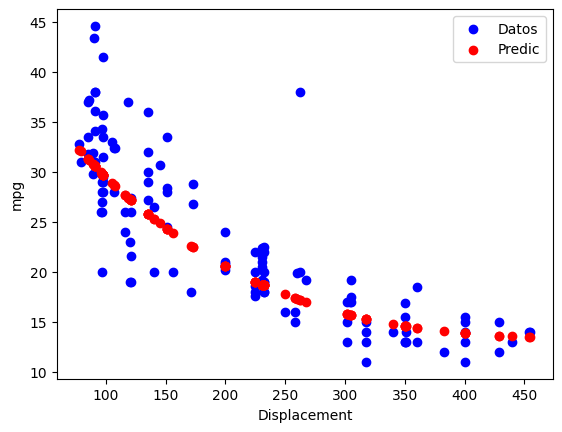

In [39]:
plt.scatter(X_test, y_test, color='blue', label="Datos")
plt.scatter(X_test, y_pred, color='red', label="Predic")
plt.xlabel("Displacement")
plt.ylabel("mpg")
plt.legend()
plt.show()

<ipython-input-21-8f3b86827c33>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


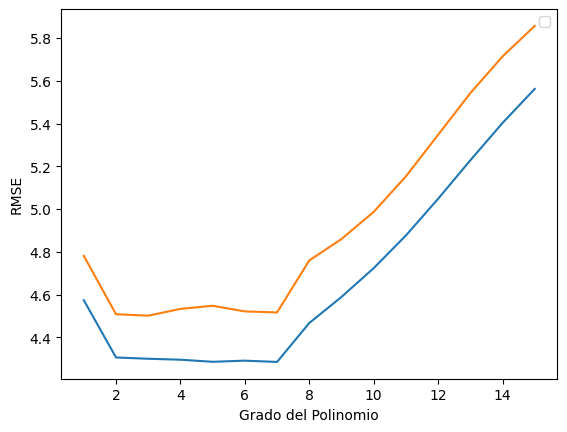

In [21]:
degrees = range(1, 16)
train= []
test= []

for grados in degrees:
    pipe = Pipeline([('poly', PolynomialFeatures(degree=grados)),('model', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    train.append(root_mean_squared_error(y_train, y_train_pred))
    test.append(root_mean_squared_error(y_test, y_test_pred))

plt.plot(degrees, train)
plt.plot(degrees, test)
plt.xlabel("Grado del Polinomio")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [22]:
grado_optimo = degrees[np.argmin(test)]
print(f"Grado óptimo del polinomio: {grado_optimo}")

pipe_optimo = Pipeline([
    ('poly', PolynomialFeatures(degree=grado_optimo)),
    ('model', LinearRegression())
])
pipe_optimo.fit(X_train, y_train)

y_train_pred_opt = pipe_optimo.predict(X_train)
y_test_pred_opt = pipe_optimo.predict(X_test)
train_opt = root_mean_squared_error(y_train, y_train_pred_opt)
test_opt = root_mean_squared_error(y_test, y_test_pred_opt)


Grado óptimo del polinomio: 3


In [20]:
print(f"RMSE Entrenamiento: {train_opt:.4f}")
print(f"RMSE Prueba: {test_opt:.4f}")

intercepto = pipe_optimo.named_steps['model'].intercept_
coeficientes = pipe_optimo.named_steps['model'].coef_

print(f"Intercepto: {intercepto:.4f}")
print(f"Coeficientes: {coeficientes}")

RMSE Entrenamiento: 4.2999
RMSE Prueba: 4.5014
Intercepto: 44.1444
Coeficientes: [ 0.00000000e+00 -1.79979044e-01  3.59170323e-04 -2.45860625e-07]
